In [1]:
import pandas as pd
import optuna
import matplotlib.pyplot as plt
import json
import numpy as np

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

e:\Informatica\venv310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read data

In [2]:
def build_df(neg_file, pos_file):
    # read csv
    neg_df = pd.read_csv(neg_file)
    pos_df = pd.read_csv(pos_file)

    pos_df["label"] = 1
    neg_df["label"] = 0

    df = pd.concat([pos_df, neg_df])

    # drop columns with a single value
    unique_columns = df.columns[df.nunique() == 1]
    df.drop(unique_columns, axis=1, inplace=True)

    # drop unique columns and version columns (they will vary over time)
    df.drop(["hash", "PackageName", "min_andrversion", "max_andrversion", "target_andrversion"], axis=1, inplace=True)

    return df

We drop columns that have unique values in each row, as well as columns with a single value, since they are not discriminative. We also drop columns related to versions, since they won't extrapolate across time.

In [3]:
df = build_df("2000_goodware_2018_2020_features.csv", "2000_malware_2018_2020_features.csv")

Let's split the data in train and test:

In [4]:
X = df.drop("label", axis=1)
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## Tuning hyperparameters

Note: since the dataset is balanced we can use accuracy as a valid metric.

In [5]:
from sklearn.metrics import make_scorer, confusion_matrix

def custom_scoring(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    weight = 4.
    total = weight * fn + fn + tn + tp
    return 1. - (weight * fn + fp) / total

scorer = make_scorer(custom_scoring, greater_is_better=True)

In [6]:
def objective(trial):
    # Define the hyperparameters to optimize
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 50),
    }

    # Create the XGBoost classifier with the hyperparameters
    classifier = XGBClassifier(**params)

    # Perform cross-validation
    scores = cross_val_score(classifier, X_train, y_train, cv=5, scoring=scorer)

    # Return the mean accuracy score as the objective value
    return scores.mean()

# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(objective, n_trials=25)

# Get the best hyperparameters and objective value
best_params = study.best_params
best_score = study.best_value

# Print the best hyperparameters and objective value
print("Best Hyperparameters:", best_params)
print("Best Objective Value:", best_score)


[I 2024-04-04 19:12:47,278] A new study created in memory with name: no-name-9f5877fb-08c2-44d6-bb78-7f214d4d3614
[I 2024-04-04 19:12:48,040] Trial 0 finished with value: 0.9437054386156378 and parameters: {'n_estimators': 155, 'max_depth': 4, 'learning_rate': 0.10740986875759909, 'subsample': 0.6180854456992512, 'colsample_bytree': 0.7834924088059079, 'gamma': 0.12899648136346187, 'reg_alpha': 1.1307685623280217, 'reg_lambda': 4.526157006712152, 'scale_pos_weight': 46.87836810617678}. Best is trial 0 with value: 0.9437054386156378.
[I 2024-04-04 19:12:48,654] Trial 1 finished with value: 0.9527904575204191 and parameters: {'n_estimators': 124, 'max_depth': 14, 'learning_rate': 0.3270700773759985, 'subsample': 0.819249146441352, 'colsample_bytree': 0.955428129715068, 'gamma': 0.7852396057747361, 'reg_alpha': 0.9900428978467313, 'reg_lambda': 8.631869852825343, 'scale_pos_weight': 22.8164612019999}. Best is trial 1 with value: 0.9527904575204191.
[I 2024-04-04 19:12:49,466] Trial 2 fini

Best Hyperparameters: {'n_estimators': 112, 'max_depth': 13, 'learning_rate': 0.2120502435843996, 'subsample': 0.671574074619681, 'colsample_bytree': 0.848355449298026, 'gamma': 0.5170904049343694, 'reg_alpha': 0.22976282904388867, 'reg_lambda': 7.809757456685931, 'scale_pos_weight': 22.699159412480405}
Best Objective Value: 0.9552911925185578


```python
best_params = {
    'n_estimators': 200,
    'max_depth': 10,
    'learning_rate': 0.09254019117978263,
    'subsample': 0.8971558521354843,
    'colsample_bytree': 0.5914997101665357,
    'gamma': 0.2789241965723543,
    'reg_alpha': 0.09006655234007827,
    'reg_lambda': 0.23580504543090375
}
```

## Evaluate the model

In [7]:
clf = XGBClassifier(**best_params)
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.848355449298026, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.5170904049343694,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2120502435843996,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=13, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=112, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [8]:
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)
print(json.dumps(report, indent=4))

{
    "0": {
        "precision": 0.9692307692307692,
        "recall": 0.9742268041237113,
        "f1-score": 0.9717223650385605,
        "support": 194.0
    },
    "1": {
        "precision": 0.975609756097561,
        "recall": 0.970873786407767,
        "f1-score": 0.9732360097323601,
        "support": 206.0
    },
    "accuracy": 0.9725,
    "macro avg": {
        "precision": 0.9724202626641651,
        "recall": 0.9725502952657392,
        "f1-score": 0.9724791873854604,
        "support": 400.0
    },
    "weighted avg": {
        "precision": 0.9725159474671671,
        "recall": 0.9725,
        "f1-score": 0.9725018920558673,
        "support": 400.0
    }
}


In [9]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
confusion_matrix / confusion_matrix.sum().sum() * 100

Predicted,0,1
Actual,,
0,47.25,1.25
1,1.50,50.00


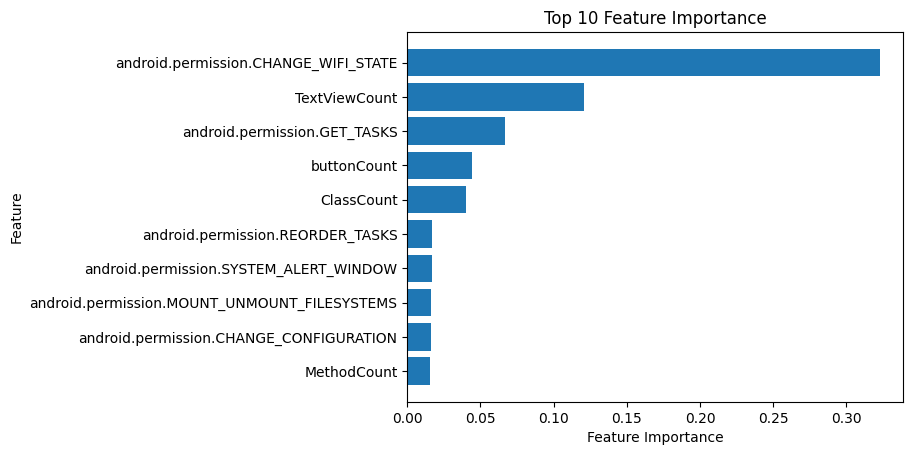

In [10]:
# Get the feature importance from the trained classifier
feature_importance = clf.feature_importances_

# Get the indices of the top 10 features
top_10_indices = feature_importance.argsort()[-10:]

# Get the names of the top 10 features
top_10_features = X.columns[top_10_indices]

# Get the importance values of the top 10 features
top_10_importance = feature_importance[top_10_indices]

# Create a bar plot of the top 10 features and their importance values
plt.barh(top_10_features, top_10_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importance')
plt.show()


In [11]:
# Get the positive and negative examples
positive_examples = df[df['label'] == 1]
negative_examples = df[df['label'] == 0]

# Get the values of the most important features
most_important_features = top_10_features.tolist()
binary_features = [feature for feature in most_important_features if len(df[feature].unique()) == 2]
numeric_features = [feature for feature in most_important_features if feature not in binary_features]

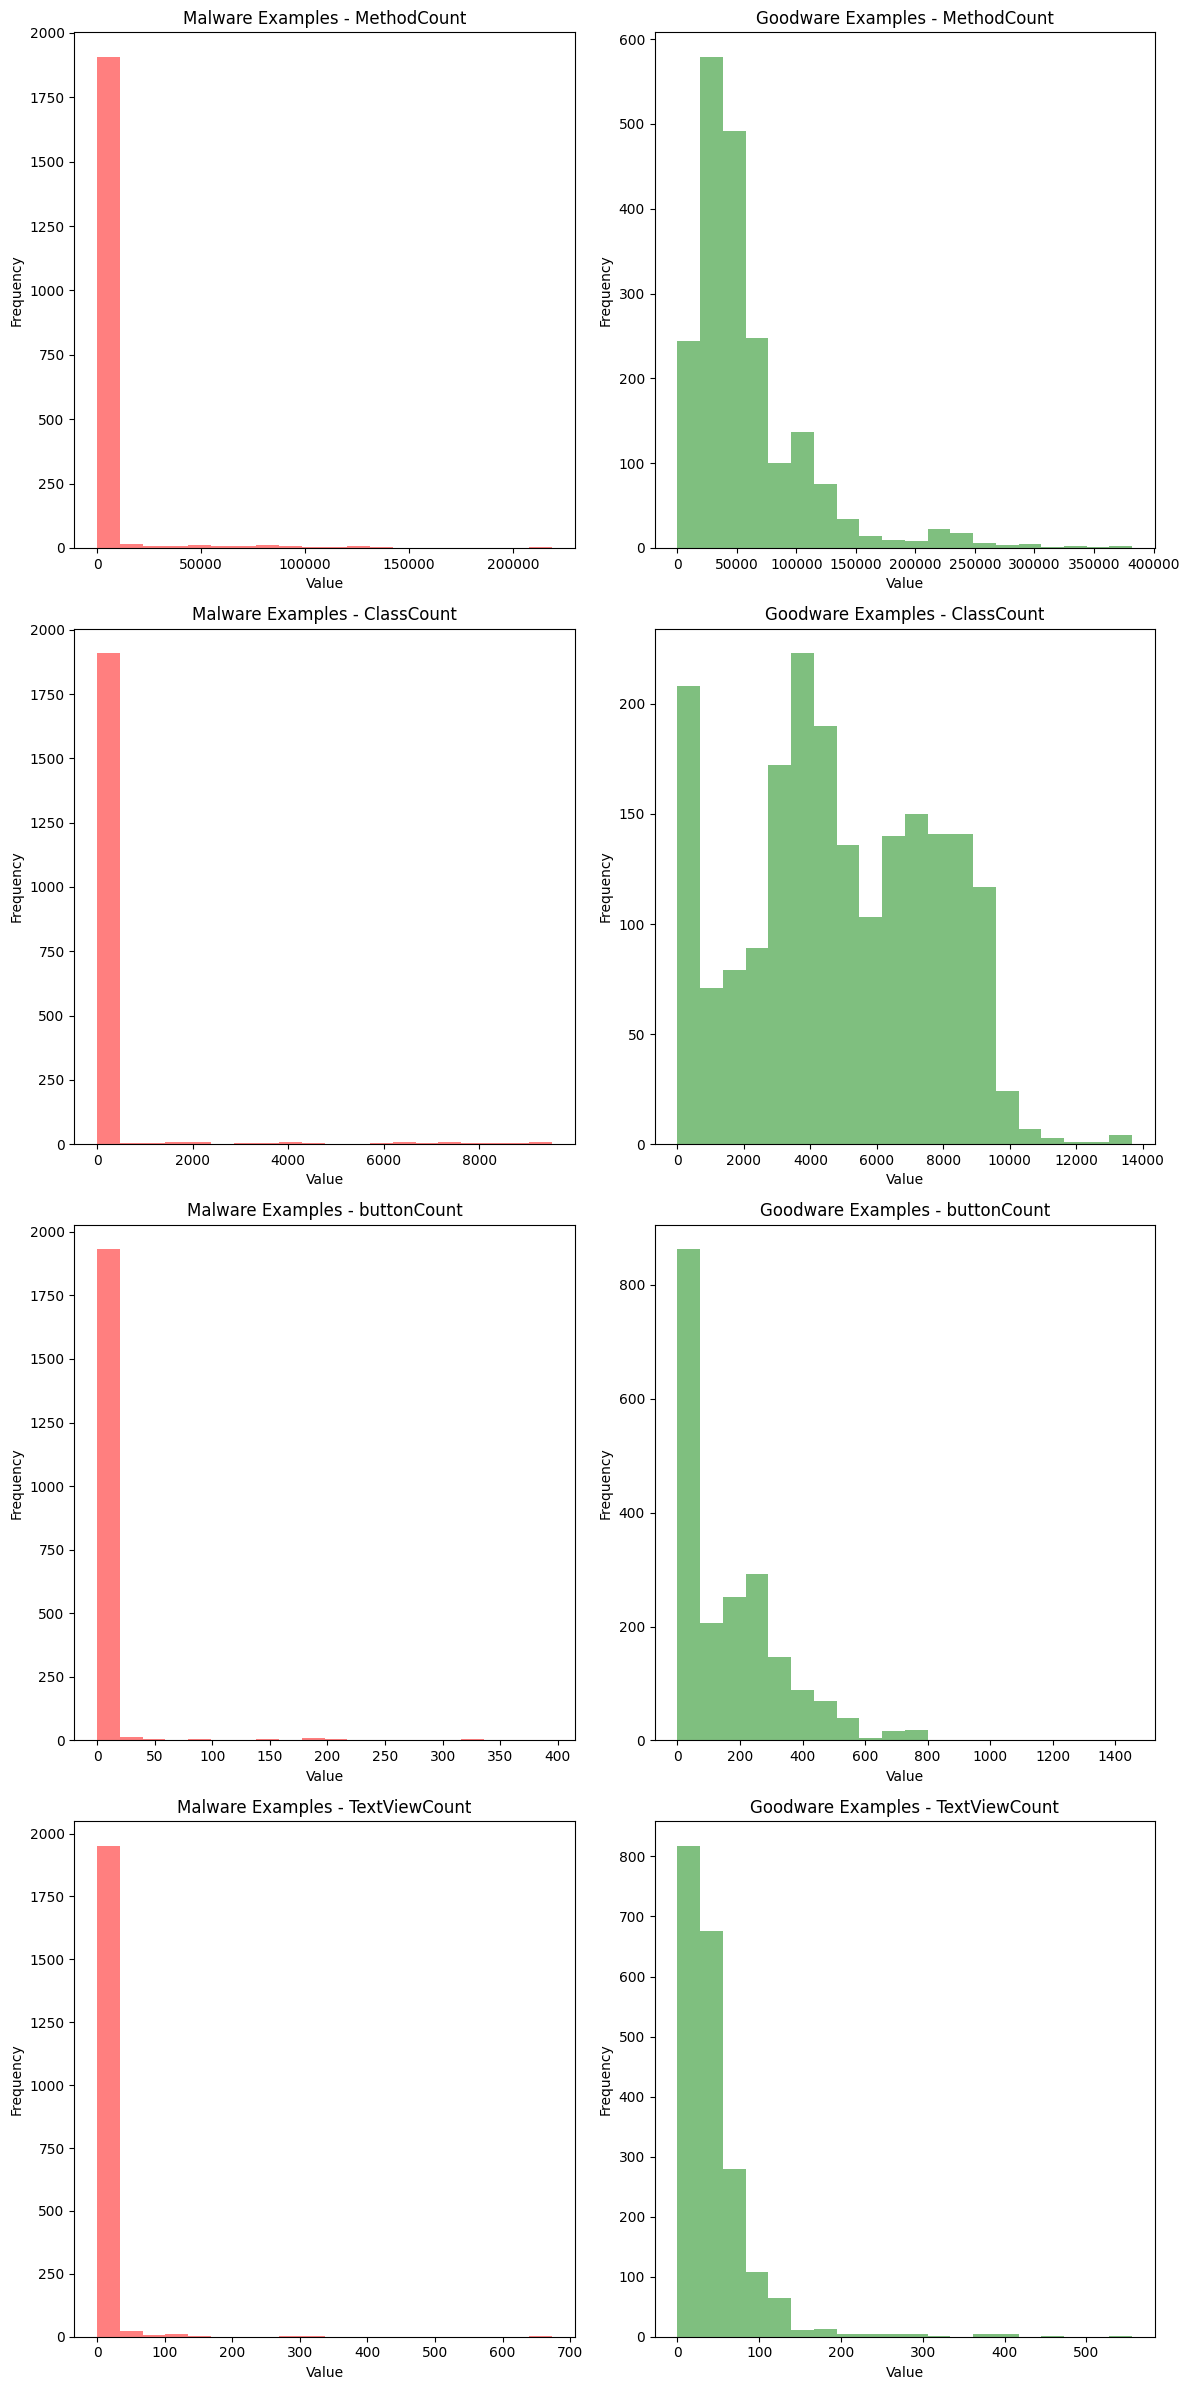

In [12]:
# Plot the distribution of the variables for both positive and negative examples
fig, axes = plt.subplots(nrows=len(numeric_features), ncols=2, figsize=(12, 6 * len(numeric_features)))

for i, feature in enumerate(numeric_features):
    # Plot the distribution for positive examples
    axes[i, 0].hist(positive_examples[feature], bins=20, color='red', alpha=0.5)
    axes[i, 0].set_title(f'Malware Examples - {feature}')
    axes[i, 0].set_xlabel('Value')
    axes[i, 0].set_ylabel('Frequency')

    # Plot the distribution for negative examples
    axes[i, 1].hist(negative_examples[feature], bins=20, color='green', alpha=0.5)
    axes[i, 1].set_title(f'Goodware Examples - {feature}')
    axes[i, 1].set_xlabel('Value')
    axes[i, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

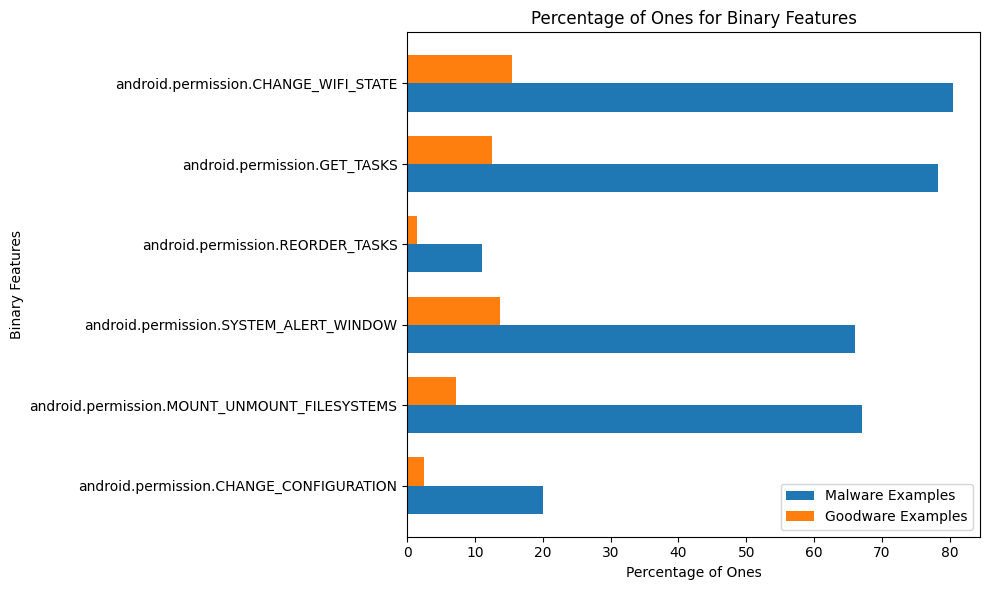

In [13]:
# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 6))
y = range(len(binary_features))
height = 0.35

# Calculate the percentage of ones for each binary feature in positive examples
positive_percentages = []
for feature in binary_features:
    positive_percentages.append(positive_examples[feature].mean() * 100)

# Calculate the percentage of ones for each binary feature in negative examples
negative_percentages = []
for feature in binary_features:
    negative_percentages.append(negative_examples[feature].mean() * 100)

# Plot the bar plots side by side
ax.barh(y, positive_percentages, height, label='Malware Examples')
ax.barh([i + height for i in y], negative_percentages, height, label='Goodware Examples')

# Set the labels, title, and ticks
ax.set_ylabel('Binary Features')
ax.set_xlabel('Percentage of Ones')
ax.set_title('Percentage of Ones for Binary Features')
ax.set_yticks([i + height/2 for i in y])
ax.set_yticklabels(binary_features)
ax.legend()

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


## Attacking the model

### Manual attack

A big difference between the two classes can be seen in the distribution graphs of the numeric variables:

The malign examples, for the most part, have a very low number in the ```('TextViewCount', 'buttonCount', 'MethodCount', 'ClassCount')``` fields, while the benign examples have a higher number in these attributes.

Therefore, we have decided to alter these variables in a benign example so that the model will return a false negative. In particular, we have focused on the ```MethodCount``` and ```ClassCount``` attributes, since they are apparently the simplest to alter in a real case by adding redundant functions or classes.

In [14]:
selected_sample = positive_examples.iloc[1].drop("label").to_frame().T
orig_preds = clf.predict(selected_sample)
selected_sample.loc[:, "ClassCount"] = 40000
selected_sample.loc[:, "MethodCount"] = 40000
attacked_preds = clf.predict(selected_sample)
print(f"predicción original: {orig_preds}\npredicción atacada: {attacked_preds}")

predicción original: [1]
predicción atacada: [0]


### Using SecML

Creation of ```CClassifier```, compatible with ```CAttackEvasionPGDLS```, class in charge of performing the attack to the new model automatically.

In [15]:
from secml.data import CDataset
from secml.ml.classifiers import CClassifierSVM
from secml.ml.features import CNormalizerMinMax
from secml.ml.kernels import CKernelRBF
from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()

# Convertir los datos a los formatos requeridos por secml
train_dataset = CDataset(X_train, y_train)
test_dataset = CDataset(X_test, y_test)

# Normalizar los datos
normalizer = CNormalizerMinMax()
train_dataset.X = normalizer.fit_transform(train_dataset.X)
test_dataset.X = normalizer.transform(test_dataset.X)

# Crear un objeto de clasificador, en este caso, usaremos SVM con un kernel RBF
clf = CClassifierSVM(kernel=CKernelRBF())

# Entrenar el clasificador
clf.fit(train_dataset.X, train_dataset.Y)

y_pred = clf.predict(test_dataset.X)
acc = metric.performance_score(y_true=test_dataset.Y, y_pred=y_pred)

print("Accuracy on test set: {:.2%}".format(acc))

Accuracy on test set: 88.50%


In [46]:
# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 1e-33,
    'eta_min': 1e-33,
    'eta_max': None,
    'max_iter': 1000,
    'eps': 1e-33
}

tr = train_dataset  # The training dataset
x0 = selected_sample.values
y0 = np.array(orig_preds)  # The target label for the evasion attack
noise_type = 'l2'  # Type of perturbation 'l1' or 'l2'
dmax = 1e33  # Maximum perturbation
lb, ub = 0, 1e8  # Bounds of the attack space. Can be set to `None` for unbounded
y_target = 0  # None if `error-generic` or a class label for `error-specific`

from secml.adv.attacks.evasion import CAttackEvasionPGDLS

pgd_ls_attack = CAttackEvasionPGDLS(
    classifier=clf,
    double_init_ds=tr,
    distance=noise_type,
    dmax=dmax,
    lb=lb, ub=ub,
    solver_params=solver_params,
    y_target=y_target)

# Run the evasion attack on x0
y_pred_pgdls, _, adv_ds_pgdls, _ = pgd_ls_attack.run(x0, y0)

print("Original x0 label: ", y0.item())
print("Adversarial example label (PGD-LS): ", y_pred_pgdls.item())

print("Number of classifier gradient evaluations: {:}"
      "".format(pgd_ls_attack.grad_eval))

2024-04-04 19:25:53,905 - py.warnings - WARNING - e:\Informatica\venv310\lib\site-packages\secml\array\c_dense.py:1162: RuntimeWarning: invalid value encountered in cast
  return self.__class__(self._data.astype(dtype))

Original x0 label:  1
Adversarial example label (PGD-LS):  0
Number of classifier gradient evaluations: 2
